In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO     2016-10-10 17:04:58,127 - kid_readout.<module>:13  kid_readout logging setup with default stream handler
INFO:kid_readout:kid_readout logging setup with default stream handler


In [3]:
import glob

In [4]:
files = glob.glob('/data/readout/2016-10-09*vna*.nc')
files +=glob.glob('/data/readout/2016-10-10*vna*.nc')
files.sort()

In [5]:
files

['/data/readout/2016-10-09_132712_vna_dac_atten_20.0_dB_heater_0.000_V.nc',
 '/data/readout/2016-10-09_140930_vna_dac_atten_20.0_dB_heater_1.291_V.nc',
 '/data/readout/2016-10-09_194243_vna_dac_atten_20.0_dB_heater_1.826_V.nc',
 '/data/readout/2016-10-09_202503_vna_dac_atten_20.0_dB_heater_2.236_V.nc',
 '/data/readout/2016-10-09_214754_vna_dac_atten_20.0_dB_heater_2.582_V.nc',
 '/data/readout/2016-10-09_230013_vna_dac_atten_20.0_dB_heater_2.887_V.nc',
 '/data/readout/2016-10-10_001226_vna_dac_atten_20.0_dB_heater_3.162_V.nc',
 '/data/readout/2016-10-10_012443_vna_dac_atten_20.0_dB_heater_3.416_V.nc',
 '/data/readout/2016-10-10_023710_vna_dac_atten_20.0_dB_heater_3.651_V.nc',
 '/data/readout/2016-10-10_112231_vna_dac_atten_20.0_dB_heater_4.830_V.nc',
 '/data/readout/2016-10-10_123447_vna_dac_atten_20.0_dB_heater_4.655_V.nc',
 '/data/readout/2016-10-10_134657_vna_dac_atten_20.0_dB_heater_4.472_V.nc',
 '/data/readout/2016-10-10_145910_vna_dac_atten_20.0_dB_heater_4.282_V.nc',
 '/data/read

In [6]:
s21 = []
s21_err = []
timestamps = []
for fn in files:
    ncf = NCFile(fn)
    swa = ncf.SweepArray0
    timestamps.append(swa.start_epoch())
    s21.append(swa.s21_point)
    s21_err.append(swa.s21_point_error)
    ncf.close()
s21 = np.array(s21)
s21_err = np.array(s21_err)
timestamps = np.array(timestamps)

In [7]:
ncf = NCFile(files[0])

In [8]:
swa = ncf.SweepArray0

In [12]:
swa.sweep(0).streams[0].roach_state

StateDict({u'boffile': u'r2bb2xpfb14mcr25_2016_Oct_01_2233.bof', u'modulation_output': 2, u'modulation_rate': 7, u'fft_shift_register': 1048560, u'num_tone_samples': 262144, u'bank': 0, u'num_filterbank_channels': 16384, u'loopback': False, u'lo_frequency': 0.0, u'adc_sample_rate': 512000000.0, u'waveform_normalization': 0.000396728515625, u'hardware_delay_samples': -32409.599999999999, u'num_tones': 128, u'debug_register': 0, u'reference_sequence_number': 3101864313, u'dac_attenuation': 20.0, u'heterodyne': False})

In [9]:
freq = swa.frequency

In [10]:
f0s = np.load('/data/readout/resonances/2016-10-04-JPL-8x8-LF-2_firstcooldown_resonances.npy')

In [11]:
data = {}
for f0 in f0s:
    mask = np.abs(f0-freq) < 25e3
    group = []
    for k in range(s21.shape[0]):
        res = lmfit_resonator.LinearResonatorWithCable(freq[mask],s21[k,mask],s21_err[k,mask])
        group.append(res)
    data[f0]=group
    

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
s21.shape

(14, 61440)

In [42]:
np.polyfit(load,1e6*(1-fset/fset.max()),1)

array([ 2.55026546, -9.07505473])

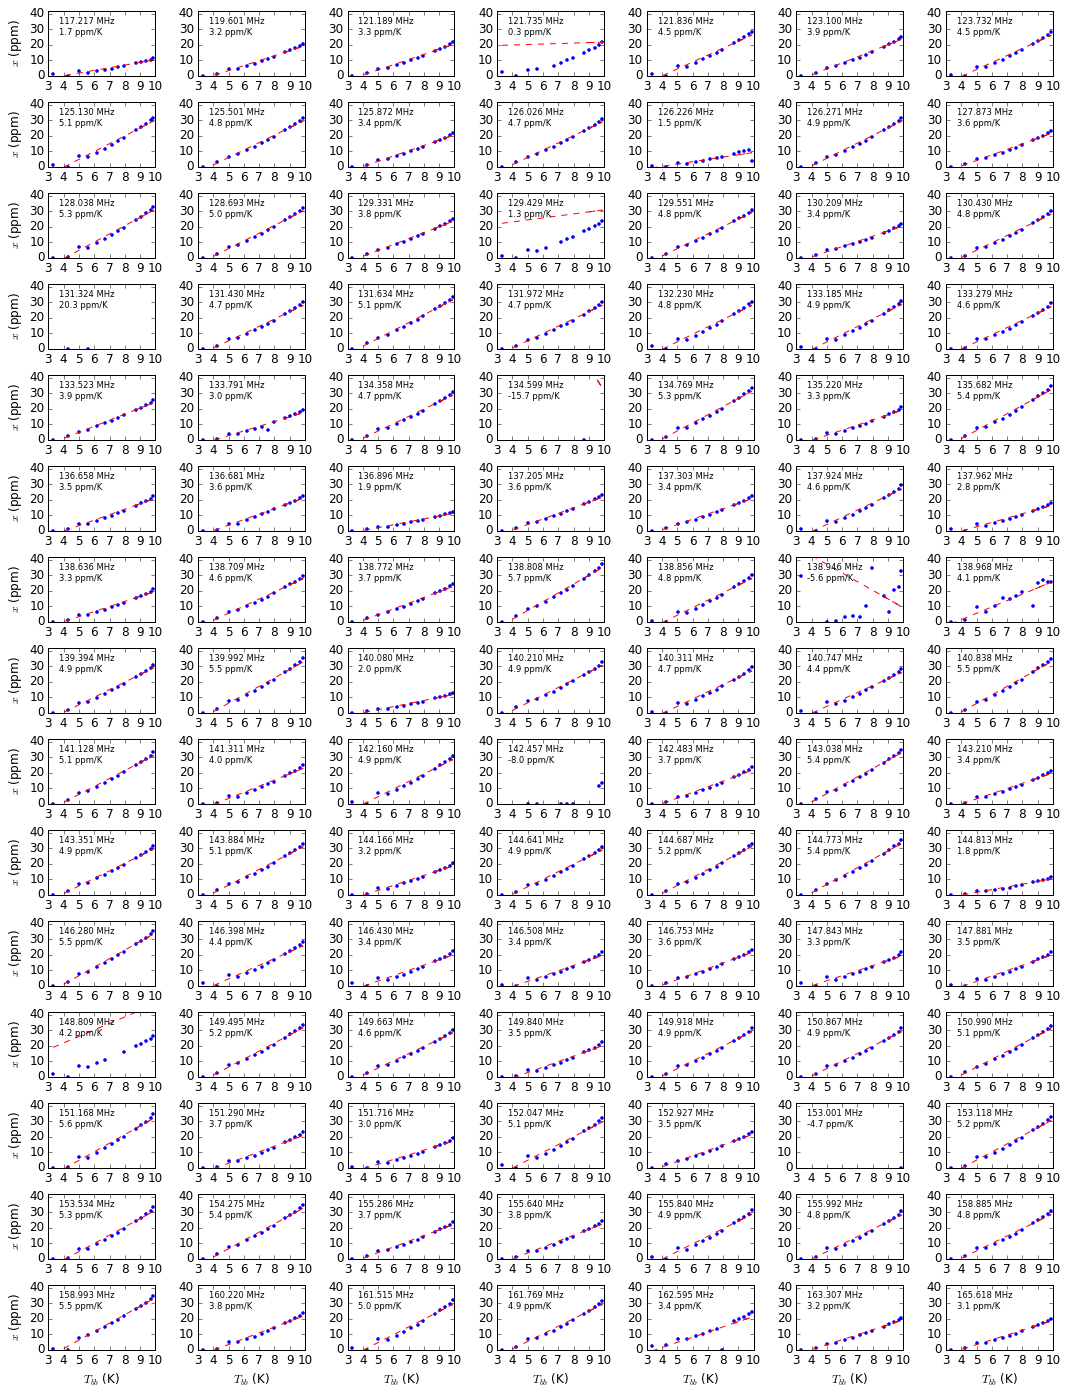

In [64]:
rcParams['font.size']=12
fig,axs = subplots(15,7,figsize=(18,24))
fig.subplots_adjust(wspace=.4,hspace=.4)
keys = data.keys()
keys.sort()
responsivities = []
for k,ax in enumerate(axs.flatten()):
    f0 = keys[k]
    group = data[f0]
    fset = np.array([res.f_0 for res in group])
    ax.plot(load,1e6*(1-fset/fset.max()),'.')
    y = 1e6*(1-fset/fset.max())
    mask = np.arange(len(y))!=2
    slope,offset = np.polyfit(load[mask],y[mask],1)
    ax.plot(load,load*slope+offset,'r--')
    ax.text(0.1,0.9,("%.3f MHz\n%.1f ppm/K" % (f0/1e6,slope)),va='top',transform=ax.transAxes,size='x-small')
    responsivities.append(slope)
    ax.set_ylim(0,42)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    
for ax in axs[:,0]:
    ax.set_ylabel('$x$ (ppm)')
for ax in axs[-1,:]:
    ax.set_xlabel('$T_{bb}$ (K)')
responsivities = np.array(responsivities)

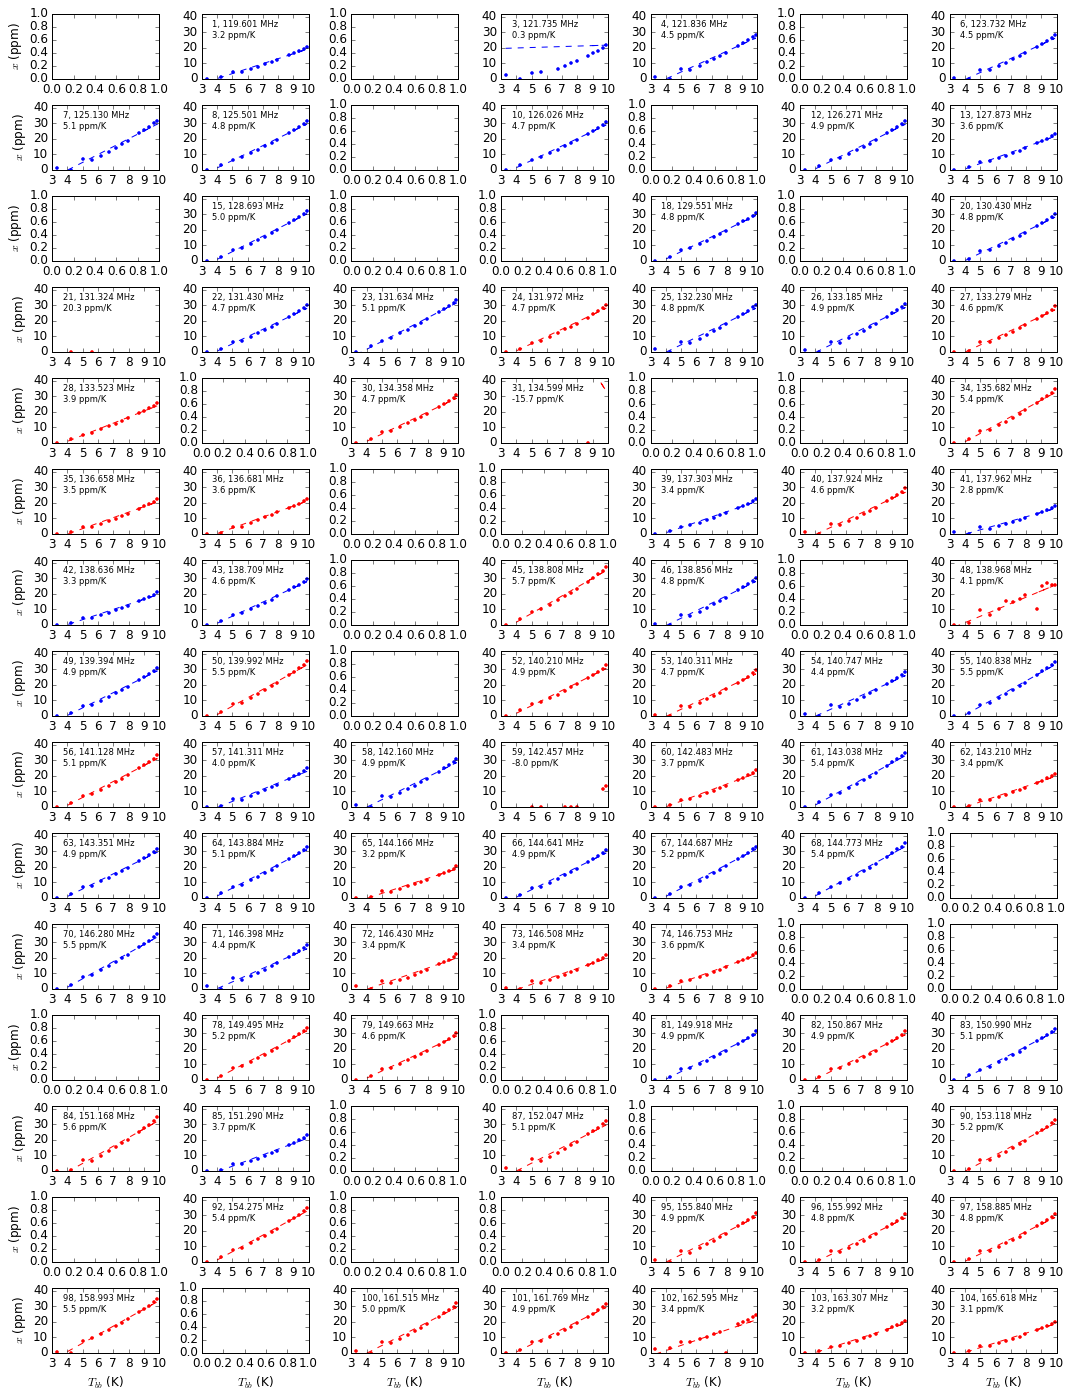

In [97]:
rcParams['font.size']=12
fig,axs = subplots(15,7,figsize=(18,24))
fig.subplots_adjust(wspace=.4,hspace=.4)
keys = data.keys()
keys.sort()
responsivities = []
for k,ax in enumerate(axs.flatten()):
    if k in pola:
        color='b'
    elif k in polb:
        color='r'
    else:
        continue
    f0 = keys[k]
    group = data[f0]
    fset = np.array([res.f_0 for res in group])
    ax.plot(load,1e6*(1-fset/fset.max()),'.',color=color)
    y = 1e6*(1-fset/fset.max())
    mask = np.arange(len(y))!=2
    slope,offset = np.polyfit(load[mask],y[mask],1)
    ax.plot(load,load*slope+offset,'--',color=color)
    ax.text(0.1,0.9,("%d, %.3f MHz\n%.1f ppm/K" % (k,f0/1e6,slope)),va='top',transform=ax.transAxes,size='x-small')
    responsivities.append(slope)
    ax.set_ylim(0,42)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    
for ax in axs[:,0]:
    ax.set_ylabel('$x$ (ppm)')
for ax in axs[-1,:]:
    ax.set_xlabel('$T_{bb}$ (K)')
responsivities = np.array(responsivities)

In [87]:
pola = np.load('/data/readout/archive/2016-10-20-jpl-lf-2-pola-relaxed.npy')
polb = np.load('/data/readout/archive/2016-10-20-jpl-lf-2-polb-relaxed.npy')

In [93]:
rcParams['text.usetex']=False

In [102]:
load

array([ 3.31      ,  4.261     ,  5.012     ,  5.61315509,  6.21      ,
        6.708     ,  7.162     ,  7.57984083,  7.958     ,  9.88      ,
        9.69      ,  9.374     ,  9.037     ,  8.716     ])

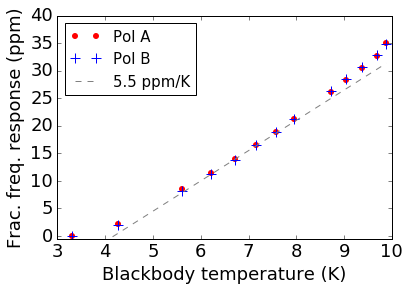

In [136]:
rcParams['font.size']=18
mask = np.arange(len(load))!=2
group = data[keys[50]]
fset = np.array([res.f_0 for res in group])
plot(load[mask],1e6*(1-fset/fset.max())[mask],'ro',mew=0,label='Pol A')
group = data[keys[55]]
fset = np.array([res.f_0 for res in group])
plot(load[mask],1e6*(1-fset/fset.max())[mask],'b+',mew=1,ms=10,label='Pol B')
x = np.linspace(load.min(),load.max(),10)
plot(x,x*5.5-23,'--',color='gray',label='5.5 ppm/K')
ylim(-0.5,40)
ylabel('Frac. freq. response (ppm)')
xlabel('Blackbody temperature (K)')
legend(loc='upper left',prop=dict(size='small'))
savefig('/home/gjones/Dropbox/proposal_figures/jpl_lf_2_black_body_response.pdf',bbox_inches='tight')

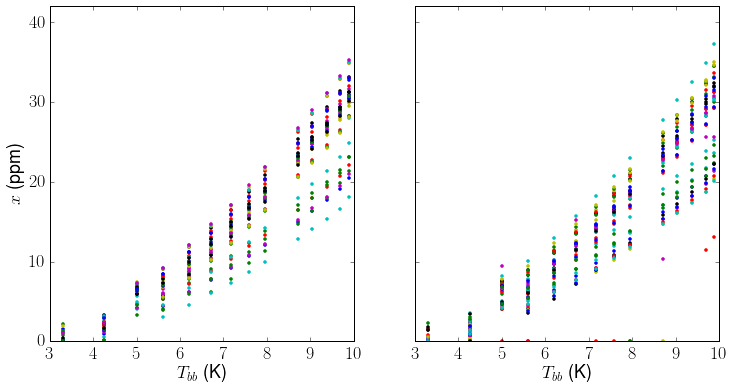

In [90]:
fig,axs = subplots(1,2,figsize=(12,6),sharex=True,sharey=True)
#fig.subplots_adjust(wspace=.4,hspace=.4)
keys = data.keys()
keys.sort()
responsivities = []
for k in range(128):
    if k in pola:
        ax = axs[0]
    elif k in polb:
        ax = axs[1]
    else:
        continue
    f0 = keys[k]
    group = data[f0]
    fset = np.array([res.f_0 for res in group])
    ax.plot(load,1e6*(1-fset/fset.max()),'.')
    y = 1e6*(1-fset/fset.max())
    mask = np.arange(len(y))!=2
    slope,offset = np.polyfit(load[mask],y[mask],1)
    #ax.plot(load,load*slope+offset,'r--')
    #ax.text(0.1,0.9,("%.3f MHz\n%.1f ppm/K" % (f0/1e6,slope)),va='top',transform=ax.transAxes,size='x-small')
    responsivities.append(slope)
    ax.set_ylim(0,42)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    
for ax in axs[:1]:
    ax.set_ylabel('$x$ (ppm)')
for ax in axs:
    ax.set_xlabel('$T_{bb}$ (K)')
responsivities = np.array(responsivities)

In [65]:
rcParams['font.size']=18

In [41]:
(responsivities<4.2).sum()

49

In [44]:
((responsivities>4.2) & (responsivities < 6)).sum()

55

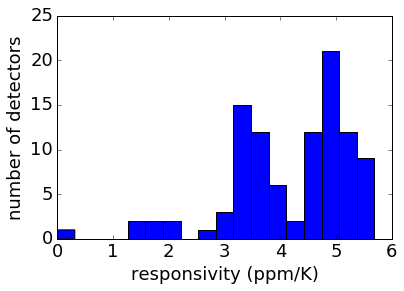

In [34]:
_=hist(responsivities,bins=np.linspace(0,6,20))
ylabel('number of detectors')
xlabel('responsivity (ppm/K)')

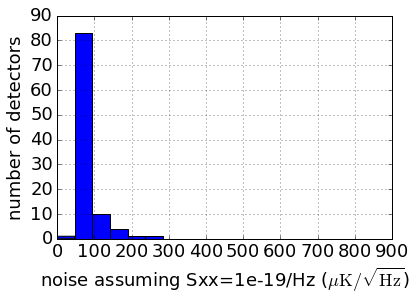

In [22]:
_=hist(np.sqrt(1e-19)*1e12/responsivities,bins=np.linspace(0,900,20))
ylabel('number of detectors')
xlabel(r'noise assuming Sxx=1e-19/Hz ($\mu\mathrm{K}/\sqrt{\mathrm{Hz}}$)')
grid()

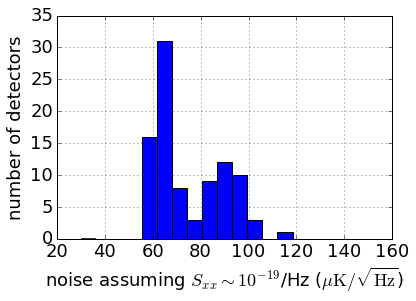

In [66]:

_=hist(np.sqrt(1e-19)*1e12/responsivities,bins=np.linspace(30,150,20))
ylabel('number of detectors')
xlabel(r'noise assuming $S_{xx}\sim 10^{-19}$/Hz ($\mu\mathrm{K}/\sqrt{\mathrm{Hz}}$)')
grid()

In [67]:
70/np.sqrt(2)

49.497474683058321

In [63]:
responsivities.mean()

3.163298653117447

In [64]:
1e-9*1e12/3.

333.33333333333337

In [53]:
(1e-9/4e-6)*1e6

250.0

In [15]:
from kid_readout.equipment import starcryo_temps

updated file list


In [16]:
pkg,_,load,_=starcryo_temps.get_temperatures_at(timestamps)

(0, 22)

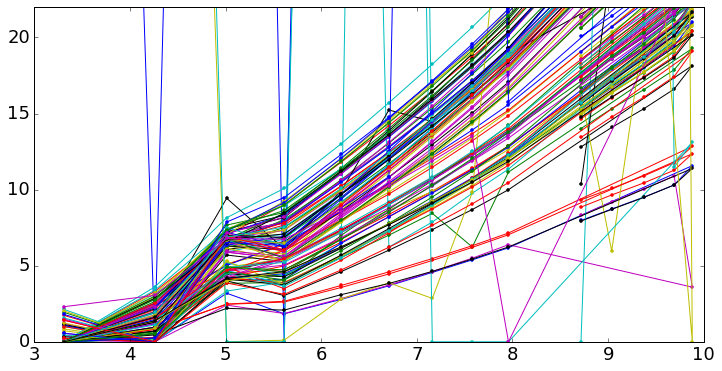

In [32]:
fig,ax = subplots(1,1,figsize=(12,6))
keys = data.keys()
keys.sort()
for k in range(len(keys)):
    f0 = keys[k]
    group = data[f0]
    fset = np.array([res.f_0 for res in group])
    ax.plot(load,1e6*(1-fset/fset.max()),'.-')
ax.set_ylim(0,22)

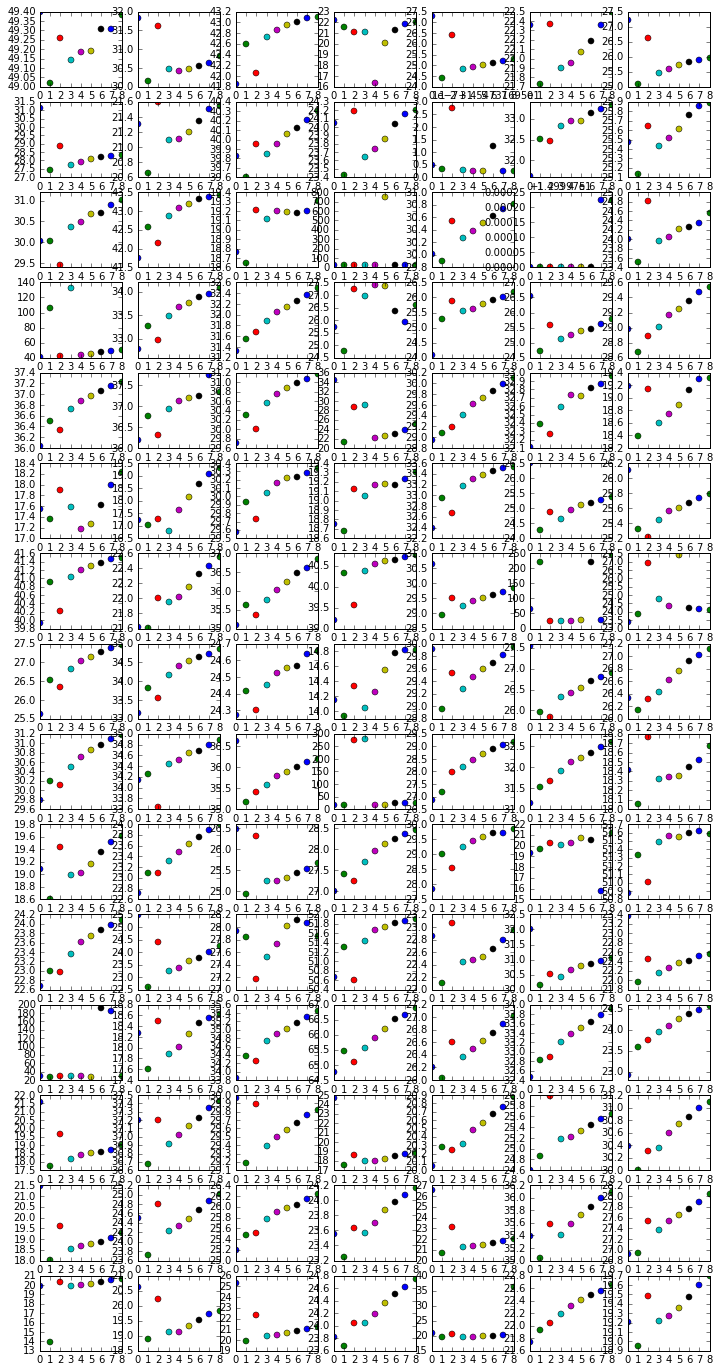

In [33]:
fig,axs = subplots(15,7,figsize=(12,24))
keys = data.keys()
keys.sort()
for k,ax in enumerate(axs.flatten()):
    f0 = keys[k]
    group = data[f0]
    for m,res in enumerate(group):
        ax.plot(m,1e6/res.Q,'o')
    ax.set_ylim()

In [18]:
s21.shape

(9, 61440)

<IPython.core.display.Javascript object>


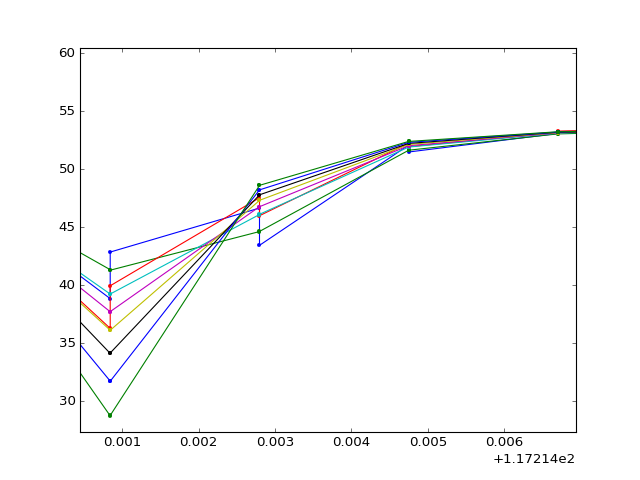

In [21]:
figure()
plot(freq,dB(s21).T,'.-')

In [20]:
3e3/131e6

2.2900763358778624e-05

In [75]:
rcParams

RcParams({u'agg.path.chunksize': 0,
          u'animation.avconv_args': [],
          u'animation.avconv_path': u'avconv',
          u'animation.bitrate': -1,
          u'animation.codec': u'mpeg4',
          u'animation.convert_args': [],
          u'animation.convert_path': u'convert',
          u'animation.ffmpeg_args': [],
          u'animation.ffmpeg_path': u'ffmpeg',
          u'animation.frame_format': u'png',
          u'animation.html': u'none',
          u'animation.mencoder_args': [],
          u'animation.mencoder_path': u'mencoder',
          u'animation.writer': u'ffmpeg',
          u'axes.axisbelow': False,
          u'axes.edgecolor': u'k',
          u'axes.facecolor': u'w',
          u'axes.formatter.limits': [-7, 7],
          u'axes.formatter.use_locale': False,
          u'axes.formatter.use_mathtext': False,
          u'axes.formatter.useoffset': True,
          u'axes.grid': False,
          u'axes.grid.axis': u'both',
          u'axes.grid.which': u'major',
     

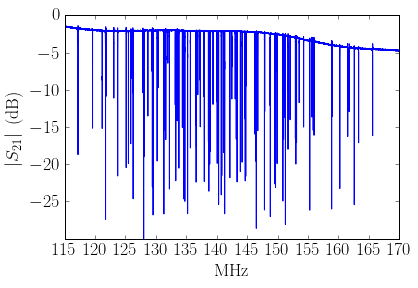

In [86]:
rcParams['text.usetex']=True
figure(figsize=(6,4))
plot(freq/1e6,dB(s21[2])-55)
ylim(-30,0)
xlabel('$\mathrm{MHz}$')
ylabel('$|S_{21}|\,\,\, \mathrm{(dB)}$')
xlim(115,170)
gca().xaxis.set_major_locator(MultipleLocator(5))
#title('8x8 dual-pol JPL-LF-2')
gca().yaxis.get_ticklabels()[0].set_visible(False)
savefig('/home/gjones/Dropbox/proposal_figures/jpl_lf_2_vna_sweep.pdf',bbox_inches='tight')